<a href="https://colab.research.google.com/github/vamsis21/oyo_projects/blob/master/optimizing_mnist_feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Driving Question
What is the optimal structure of a feedforward network with a total of 100 hidden neurons in classifying the MNIST dataset? \\
How does the architecture of the network have an effect on training time and accuracy? \\
Essentially, I want to optimize the hyperparameters of a simple network to perform well on MNIST.
### Proposed Methods
I want to distribute 100 neurons among some k layers, where a base network architecture (no dropouts) will be defined as a sequence of nonzero layers. \\
I will do this a large number of times, store architecture, timing, and accuracy/loss data, and analyze the results for the approximate best architecture.
1. Initialize a certain architecture. \\
    a. Distribute the 100 neurons among the layers. \\
    b. Add a Flatten layer at input. \\
    c. Add dropout layers after either the most dense layer or after the layers above a certain density threshold. \\
    d. Add a layer with softmax at the end. 
2. Construct the MNIST network represented by the architecture. \\
    a. Train the MNIST network for 15 epochs and record accuracy and loss, as well as time from training start to training finish. \\
    b. Keep randomly generating MNIST networks (up to 50) using the GPU runtime.


### Code

In [100]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from google.colab import drive
from ast import literal_eval
import seaborn as sns
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Getting MNIST data. 
# Note: I am training all networks on the SAME training data and testing them on the SAME testing data.
# This makes sure that the data is standard for all networks.
mnist = tf.keras.datasets.mnist
(training_input,training_targets),(test_input,test_targets) = mnist.load_data()
# Scale inputs to be between 0-255
training_input,test_input = training_input/255,test_input/255
# Input dimensions
training_n,training_l,training_w=training_input.shape

11493376/11490434 [==============================] - 0s 0us/step


This function acts as our initialization of a network architecture. We pick the number of neurons, the number of layers they're spread out across, and the dropout threshold. The dropout threshold is a fixed percentage indicating the maximum share of neurons a layer can have before it is followed by a dropout layer. I will hold the dropout threshold at 15% more than the average density of the layers. For example, in a 5 layer network with 150 neurons, the dropout threshold is 100/5 + 0.15*100 = 35% (a touch more than 1 SD above the average). \\
Note: all layers will be nonzero other than dropout layers. This allows us to filter out the dropout layers when sequentially constructing our network.

In [3]:
def generate_random_architecture(neurons,layers):
    # Creating the layers as randomly distributed integers, then normalizing them and making the sum = to neurons.
    initial_layers = np.random.randint(low=1,high=neurons,size=layers)
    initial_layers = ((initial_layers/np.sum(initial_layers))*neurons).round()
    dropout_thresh = 100/layers + 0.1*neurons

    if np.sum(initial_layers) != neurons:
        # Making sure the array will sum to exactly the right number of neurons by adding the difference from rounding (+-1) to a random layer
        pos = np.random.randint(low=0,high=len(initial_layers)-1)
        initial_layers[pos]+=neurons-np.sum(initial_layers)
    
    dropout_pos = np.array([])
    # Finding where to add the dropout layers
    for i in range(0,len(initial_layers)):
        if initial_layers[i]/neurons >= dropout_thresh/100:
            dropout_pos = np.append(dropout_pos,i)

    before_dropouts = len(initial_layers)
    if len(dropout_pos)>0:
        # Adding dropout layers
        for i in range(0,len(dropout_pos)):
            if int(dropout_pos[i])==before_dropouts:
                initial_layers = np.append(initial_layers,0)
            else:
                initial_layers = np.insert(initial_layers,int(dropout_pos[i])+1+len(initial_layers)-before_dropouts,0)
    else:
        # No layer is above the dropout threshold, so we add a dropout layer directly after the most dense layer.
        max_pos = np.argmax(initial_layers)
        initial_layers = np.insert(initial_layers,max_pos+1,0)
    return initial_layers

Here, I generate an example random architecture and build and train the MNIST network off of it. This is just a test before I implement the data collection loop. Training time is reduced to 10 epochs for demonstration purposes.

In [4]:
# Creating architecture
example_network = generate_random_architecture(100,3)

### Instantiate model ###
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(training_w,training_l)))
for i in range(0,len(example_network)):
    if int(example_network[i])!=0:
        model.add(tf.keras.layers.Dense(example_network[i],activation='relu'))
    else:
        model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(10,activation='softmax'))
### Compiling Model ###
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')
### Fitting Model ###
tic = time.clock()
model_results = model.fit(training_input,training_targets,
                          validation_data=(test_input,test_targets),
                          epochs=10)
toc =  time.clock()
elapsed_time = toc-tic

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7458 - accuracy: 0.8144 - val_loss: 0.3263 - val_accuracy: 0.9365
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2822 - accuracy: 0.9387 - val_loss: 0.2039 - val_accuracy: 0.9523
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1948 - accuracy: 0.9525 - val_loss: 0.1721 - val_accuracy: 0.9570
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1564 - accuracy: 0.9605 - val_loss: 0.1464 - val_accuracy: 0.9623
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1340 - accuracy: 0.9648 - val_loss: 0.1626 - val_accuracy: 0.9534
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1206 - accuracy: 0.9682 - val_loss: 0.1410 - val_accuracy: 0.9609
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1064 - accuracy: 0.9707 - val_loss: 0.1268 - val_accuracy:

In [5]:
model.summary() # We verify that the model is constructed based off the example_network architecture.
print('Generated Architecture: ', example_network)
print('Training Time Elapsed: ', elapsed_time)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 43)                33755     
_________________________________________________________________
dense_1 (Dense)              (None, 53)                2332      
_________________________________________________________________
dropout (Dropout)            (None, 53)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 216       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50        
Total params: 36,353
Trainable params: 36,353
Non-trainable params: 0
____________________________________________________

Now, I start to collect data. I write a function `network_data_collector` that takes in `(neurons,layers,iterations,df)`, iteratively generates an architecture using `generate_random_architecture`, builds and trains a model with this architecture, then passes in the resulting data to a list of DataFrames. I then unpack this list into the frames I will use to analyze the data.

In [6]:
# Instantiating DataFrames
column_names = ['architecture','training_accuracy','training_loss','validation_accuracy','validation_loss','training_time']
single_layer = pd.DataFrame(columns=column_names)
two_layer = pd.DataFrame(columns=column_names)
three_layer = pd.DataFrame(columns=column_names)
four_layer = pd.DataFrame(columns=column_names)
five_layer = pd.DataFrame(columns=column_names)

In [7]:
def network_data_collector(neurons,layers,iterations,df):
    for n in range(0,iterations):
        # Create dictionary to hold data for the iteration
        iteration_data = {'Iter':[]}

        # Creating architecture
        architecture = generate_random_architecture(neurons,layers)

        # Instantiating model and flattening input
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(training_w,training_l)))

        # Adding layers according to generated architecture 
        for l in range(0,len(architecture)):
            if int(architecture[l])!=0:
                model.add(tf.keras.layers.Dense(architecture[l],activation='relu'))
            else:
                model.add(tf.keras.layers.Dropout(0.2))

        # Adding softmax layer
        model.add(tf.keras.layers.Dense(10,activation='softmax'))

        # Compiling model
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics='accuracy')
        
        # Fitting model, starting the timer
        tic = time.clock()
        model_results = model.fit(training_input,training_targets,
                                  validation_data=(test_input,test_targets),
                                  epochs=15,
                                  verbose=0)
        toc =  time.clock()
        elapsed_time = toc-tic

        # Transfer data to dictionary
        iteration_data['Iter'].append(architecture)
        iteration_data['Iter'].append(model_results.history['accuracy'])
        iteration_data['Iter'].append(model_results.history['loss'])
        iteration_data['Iter'].append(model_results.history['val_accuracy'])
        iteration_data['Iter'].append(model_results.history['val_loss'])
        iteration_data['Iter'].append(elapsed_time)

        # Turn dictionary into DataFrame and append to existing DF
        iteration_df = pd.DataFrame.from_dict(data=iteration_data,
                                              orient='index',
                                              columns=column_names)
        df = df.append(iteration_df)

        # Printing progress
        print(str((n+1)*100/iterations)+'% done with the current layer setting.')
        print('Training time of the '+str(n+1)+'th iteration: '+ str(elapsed_time))
    
    return df

In [8]:
# Generating data for architectures and storing it in the respective DataFrame
layer_array = [single_layer,two_layer,three_layer,four_layer,five_layer]
for i in range(0,len(layer_array)):
    layer_array[i] = network_data_collector(neurons=100,
                                layers=i+1,
                                iterations=50,
                                df=layer_array[i])

2.0% done with the current layer setting.
Training time of the 1th iteration: 46.361763999999994
4.0% done with the current layer setting.
Training time of the 2th iteration: 46.969903000000016
6.0% done with the current layer setting.
Training time of the 3th iteration: 46.167077000000006
8.0% done with the current layer setting.
Training time of the 4th iteration: 46.18571600000001
10.0% done with the current layer setting.
Training time of the 5th iteration: 46.42709099999996
12.0% done with the current layer setting.
Training time of the 6th iteration: 45.94339600000001
14.0% done with the current layer setting.
Training time of the 7th iteration: 46.025007000000016
16.0% done with the current layer setting.
Training time of the 8th iteration: 47.74514799999997
18.0% done with the current layer setting.
Training time of the 9th iteration: 46.17938700000002
20.0% done with the current layer setting.
Training time of the 10th iteration: 45.85363699999999
22.0% done with the current l

In [9]:
# Unpacking master dataframes
single_layer,two_layer,three_layer,four_layer,five_layer = layer_array
dataframe_list = [single_layer,two_layer,three_layer,four_layer,five_layer]

In [10]:
# Mount Drive. Make sure to fill the DataFrames in the right way!
drive.mount('/content/drive')
path = '/content/drive/My Drive/colab projects/bestANNforMNIST/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
# Resetting index of master frame for time analysis
iter_cols = ['iter'+str(i) for i in range(1,51)]
for df in dataframe_list:
    df['IterNumber'] = iter_cols
    df.set_index('IterNumber',inplace=True)
single_layer.head()

,architecture,training_accuracy,training_loss,validation_accuracy,validation_loss,training_time
IterNumber,,,,,,
iter1,"[100.0, 0.0]","[0.9087333083152771, 0.9533500075340271, 0.963...","[0.31473466753959656, 0.15702681243419647, 0.1...","[0.954800009727478, 0.96670001745224, 0.972800...","[0.15023456513881683, 0.11228183656930923, 0.0...",46.361764
iter2,"[100.0, 0.0]","[0.9075166583061218, 0.952833354473114, 0.9626...","[0.318884015083313, 0.15978488326072693, 0.120...","[0.9545000195503235, 0.9672999978065491, 0.969...","[0.15471678972244263, 0.10882075130939484, 0.0...",46.969903
iter3,"[100.0, 0.0]","[0.9061499834060669, 0.9531499743461609, 0.963...","[0.3225575089454651, 0.1594972014427185, 0.120...","[0.9544000029563904, 0.9664999842643738, 0.970...","[0.15305769443511963, 0.11359856277704239, 0.0...",46.167077
iter4,"[100.0, 0.0]","[0.9110000133514404, 0.9531333446502686, 0.963...","[0.313833624124527, 0.15807776153087616, 0.119...","[0.9526000022888184, 0.9682999849319458, 0.972...","[0.15557897090911865, 0.10885096341371536, 0.0...",46.185716
iter5,"[100.0, 0.0]","[0.9072166681289673, 0.9537333250045776, 0.964...","[0.3202570974826813, 0.15700462460517883, 0.11...","[0.95660001039505, 0.9688000082969666, 0.97200...","[0.14483794569969177, 0.10715014487504959, 0.0...",46.427091


In [68]:
# Here, I'm isolating the data into separate DataFrames of a similar type. This allows me to train once and 
# then use that data again by reuploading it from csv. If I keep different datatypes in the same DataFrame, 
# it saves them as a string, which is difficult to parse back into the original master dataframes.
# I save the architectures in architectures_dict, the vectorized history data into vectorized_acc_loss, and 
# I keep the time data in the original DataFrame.
save_names = ['single_layer','two_layer','three_layer','four_layer','five_layer']
layer_lengths = [j for j in range(3,8)]
cols_to_vectorize = ['training_accuracy','training_loss','validation_accuracy','validation_loss']
cols_to_drop = ['architecture']+cols_to_vectorize

# Creating dictionary with all architectures
architectures_dict = {}
for (df,name,layer_length) in zip(dataframe_list,save_names,np.array(layer_lengths)):
    architectures_dict[name+'_architectures'] = df['architecture'].apply(pd.Series).transpose()

# Creating dictionary with vectorized model history data
vectorized_acc_loss = {}
for df,name in zip(dataframe_list,save_names):
    for col in cols_to_vectorize:
        vectorized_acc_loss[name+'_'+col] = df[col].apply(pd.Series).transpose()
        vectorized_acc_loss[name+'_'+col].columns = iter_cols
        vectorized_acc_loss[name+'_'+col]['epoch'] = [i for i in range(1,16)]
    df.drop(cols_to_drop,axis=1,inplace=True)
    



In [69]:
# Save architectures
for key in architectures_dict.keys():
    architectures_dict[key].to_csv(path+'/architectures/'+key+'.csv')

# Save history data
for key in vectorized_acc_loss.keys():
    vectorized_acc_loss[key].to_csv(path+'/history/'+key+'.csv')

# Save timing data
for df,name in zip(dataframe_list,save_names):
    df.to_csv(path+'/timing/'+name+'_timing.csv')

In [70]:
# Run this code when reloading the data from google drive. make sure to run only the imports, 
# mount the drive, and then run this cell!
architectures_dict = {}
vectorized_acc_loss = {}
timing_dict = {}
save_names = ['single_layer','two_layer','three_layer','four_layer','five_layer']
cols_to_vectorize = ['training_accuracy','training_loss','validation_accuracy','validation_loss']
for name in save_names:
    for col in cols_to_vectorize:
        vectorized_acc_loss[name+'_'+col] = pd.read_csv(path+'/history/'+name+'_'+col+'.csv')
        vectorized_acc_loss[name+'_'+col].drop('Unnamed: 0',axis=1,inplace=True)
    architectures_dict[name] = pd.read_csv(path+'/architectures/'+name+'_architectures.csv')
    timing_dict[name] = pd.read_csv(path+'/timing/'+name+'_timing.csv',index_col='IterNumber')


### Analysis

Now, I produce the accuracy/loss plots for the different layer parameters I looked at.

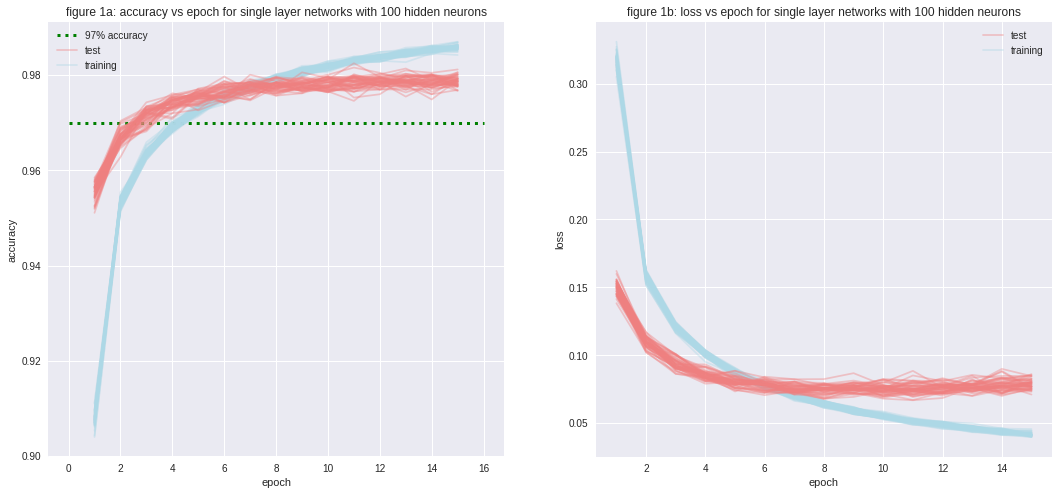

In [58]:
fig1 = plt.figure(figsize=(18,8))

ax1a = fig1.add_subplot(1,2,1)
ax1a.plot(vectorized_acc_loss['single_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['single_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax1a.plot(vectorized_acc_loss['single_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['single_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax1a.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax1a.legend(handles, labels, loc='best')
ax1a.set_xlabel('epoch')
ax1a.set_ylabel('accuracy')
ax1a.set_title('figure 1a: accuracy vs epoch for single layer networks with 100 hidden neurons')

ax1b = fig1.add_subplot(1,2,2)
ax1b.plot(vectorized_acc_loss['single_layer_training_loss']['epoch'],
          vectorized_acc_loss['single_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax1b.plot(vectorized_acc_loss['single_layer_validation_loss']['epoch'],
          vectorized_acc_loss['single_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax1b.legend(handles, labels, loc='best')
ax1b.set_xlabel('epoch')
ax1b.set_ylabel('loss')
ax1b.set_title('figure 1b: loss vs epoch for single layer networks with 100 hidden neurons')
plt.show()

For the single-layer networks, there were no initial accuracies post-1 epoch training < 90%. Basically, all of the accuracy and loss plots fit on the graphs without losing much detail. Due to the much more variable nature of distributing 100 neurons among multiple layers (total of 99 ways for two layers, and for three layers $\binom{100-1}{3-1} \approx 151,000$). \\
I first plot all generated networks' accuracy and loss vs epoch, then focus in on those which were in the neighborhood of the desired minimum accuracy (97%).

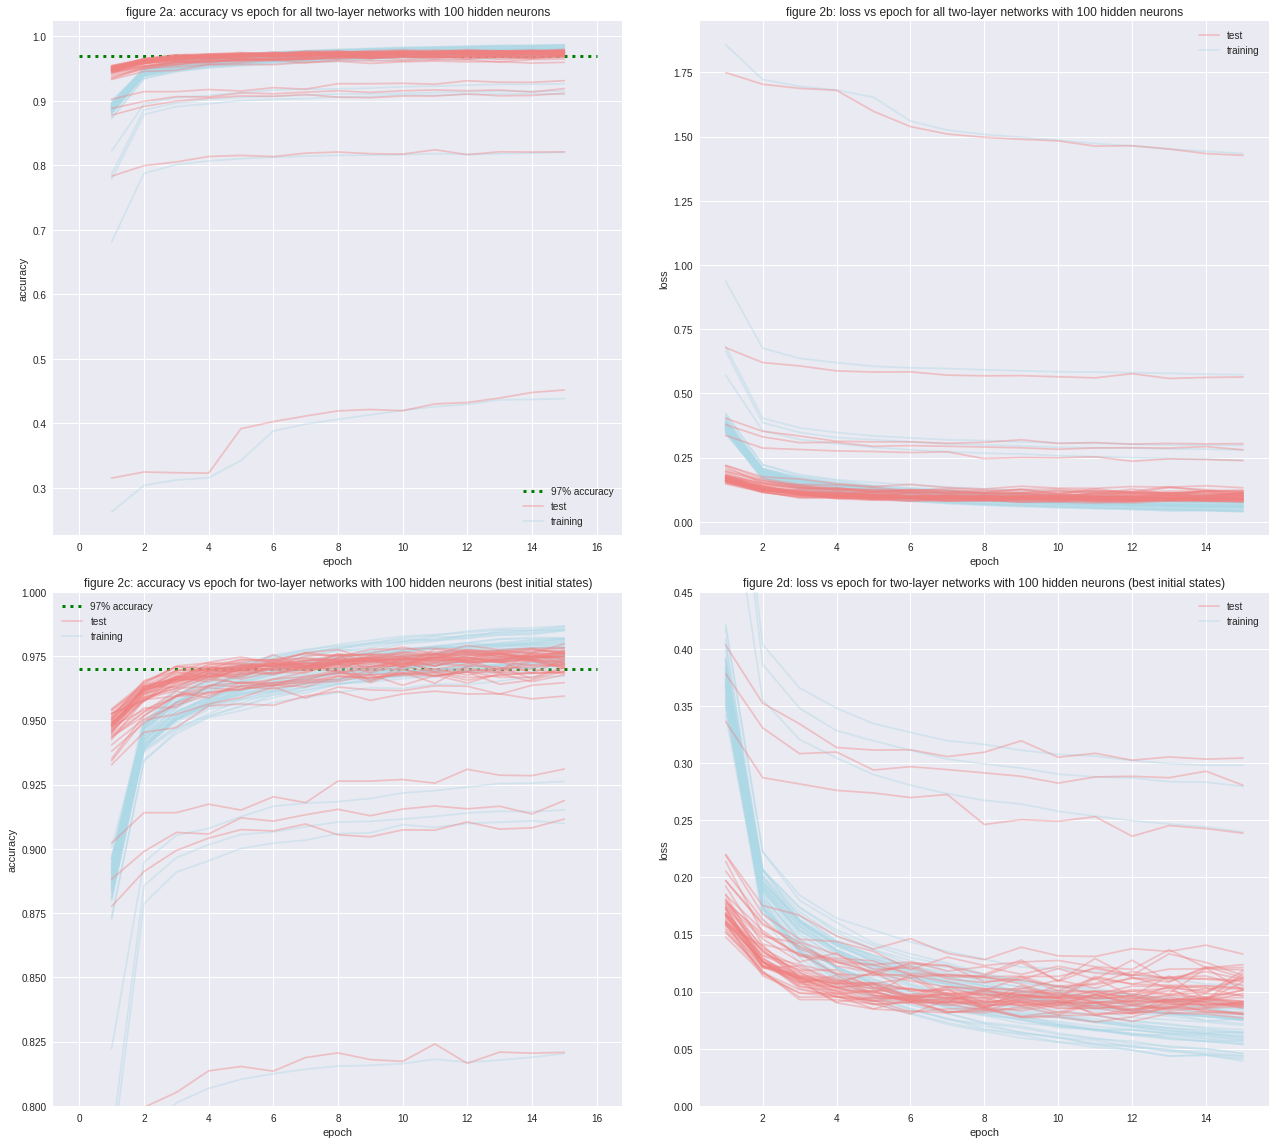

In [59]:
fig2 = plt.figure(figsize=(18,16))

ax2a = fig2.add_subplot(2,2,1)
ax2a.plot(vectorized_acc_loss['two_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['two_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax2a.plot(vectorized_acc_loss['two_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['two_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax2a.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2a.legend(handles, labels, loc='best')
ax2a.set_xlabel('epoch')
ax2a.set_ylabel('accuracy')
ax2a.set_title('figure 2a: accuracy vs epoch for all two-layer networks with 100 hidden neurons')

ax2b = fig2.add_subplot(2,2,2)
ax2b.plot(vectorized_acc_loss['two_layer_training_loss']['epoch'],
          vectorized_acc_loss['two_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax2b.plot(vectorized_acc_loss['two_layer_validation_loss']['epoch'],
          vectorized_acc_loss['two_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2b.legend(handles, labels, loc='best')
ax2b.set_xlabel('epoch')
ax2b.set_ylabel('loss')
ax2b.set_title('figure 2b: loss vs epoch for all two-layer networks with 100 hidden neurons')

ax2c = fig2.add_subplot(2,2,3)
ax2c.plot(vectorized_acc_loss['two_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['two_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax2c.plot(vectorized_acc_loss['two_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['two_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax2c.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
ax2c.set_ylim(0.8,1.0)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2c.legend(handles, labels, loc='best')
ax2c.set_xlabel('epoch')
ax2c.set_ylabel('accuracy')
ax2c.set_title('figure 2c: accuracy vs epoch for two-layer networks with 100 hidden neurons (best initial states)')

ax2d = fig2.add_subplot(2,2,4)
ax2d.plot(vectorized_acc_loss['two_layer_training_loss']['epoch'],
          vectorized_acc_loss['two_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax2d.plot(vectorized_acc_loss['two_layer_validation_loss']['epoch'],
          vectorized_acc_loss['two_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
ax2d.set_ylim(0,0.45)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2d.legend(handles, labels, loc='best')
ax2d.set_xlabel('epoch')
ax2d.set_ylabel('loss')
ax2d.set_title('figure 2d: loss vs epoch for two-layer networks with 100 hidden neurons (best initial states)')

plt.tight_layout()
plt.show()


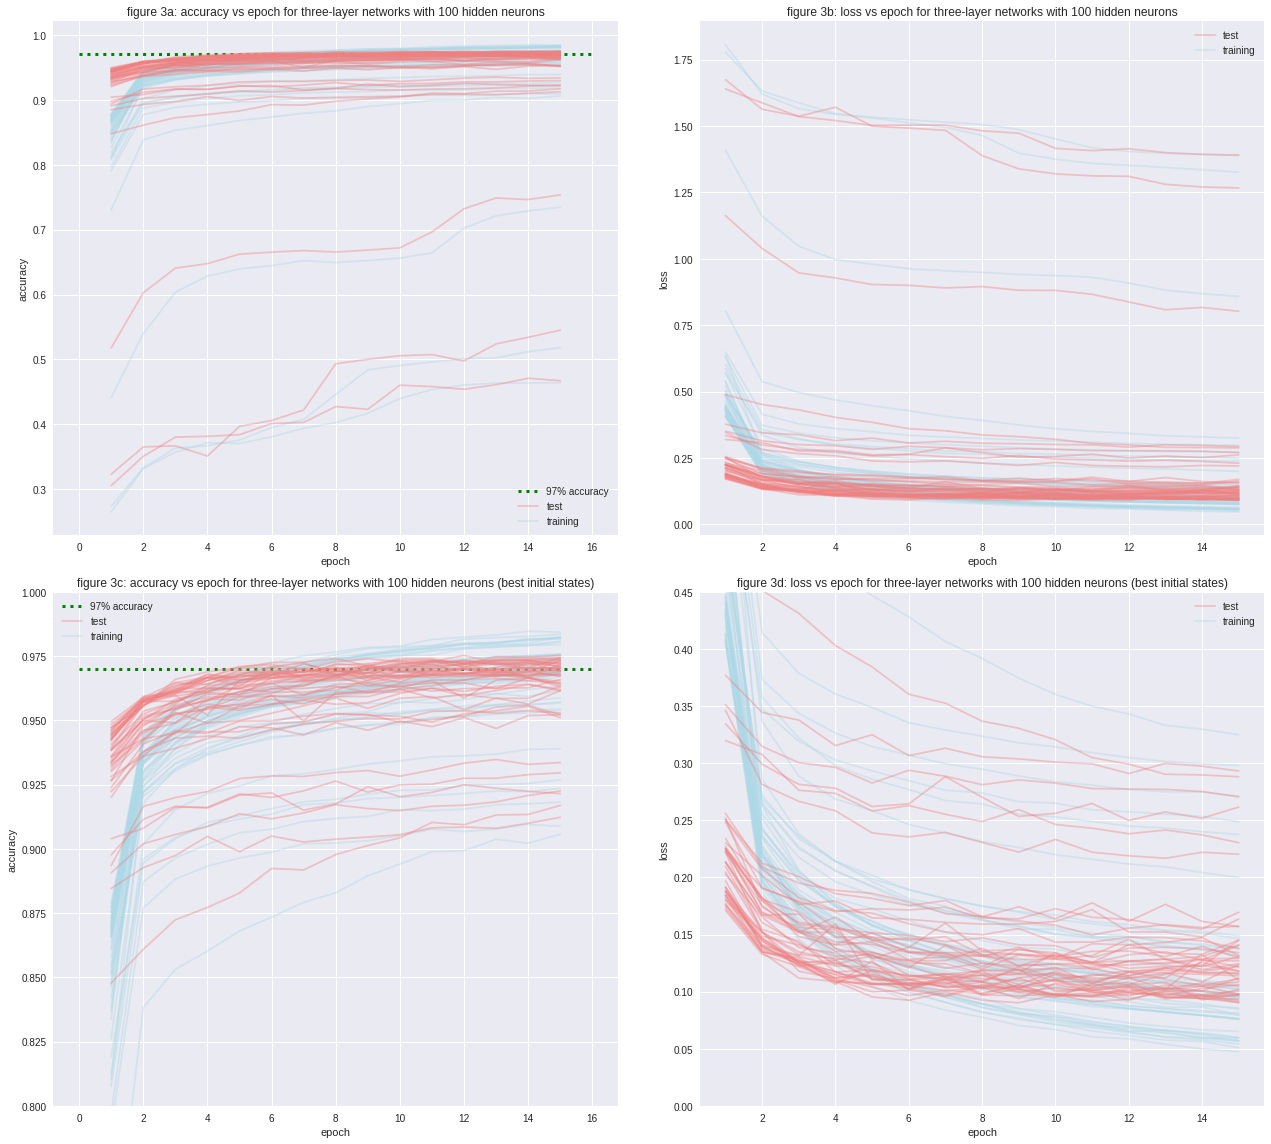

In [60]:
fig3 = plt.figure(figsize=(18,16))

ax3a = fig3.add_subplot(2,2,1)
ax3a.plot(vectorized_acc_loss['three_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['three_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax3a.plot(vectorized_acc_loss['three_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['three_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax3a.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax3a.legend(handles, labels, loc='best')
ax3a.set_xlabel('epoch')
ax3a.set_ylabel('accuracy')
ax3a.set_title('figure 3a: accuracy vs epoch for three-layer networks with 100 hidden neurons')

ax3b = fig3.add_subplot(2,2,2)
ax3b.plot(vectorized_acc_loss['three_layer_training_loss']['epoch'],
          vectorized_acc_loss['three_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax3b.plot(vectorized_acc_loss['three_layer_validation_loss']['epoch'],
          vectorized_acc_loss['three_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax3b.legend(handles, labels, loc='best')
ax3b.set_xlabel('epoch')
ax3b.set_ylabel('loss')
ax3b.set_title('figure 3b: loss vs epoch for three-layer networks with 100 hidden neurons')

ax3c = fig3.add_subplot(2,2,3)
ax3c.plot(vectorized_acc_loss['three_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['three_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax3c.plot(vectorized_acc_loss['three_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['three_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax3c.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
ax3c.set_ylim(0.8,1.0)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax3c.legend(handles, labels, loc='best')
ax3c.set_xlabel('epoch')
ax3c.set_ylabel('accuracy')
ax3c.set_title('figure 3c: accuracy vs epoch for three-layer networks with 100 hidden neurons (best initial states)')

ax3d = fig3.add_subplot(2,2,4)
ax3d.plot(vectorized_acc_loss['three_layer_training_loss']['epoch'],
          vectorized_acc_loss['three_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax3d.plot(vectorized_acc_loss['three_layer_validation_loss']['epoch'],
          vectorized_acc_loss['three_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
ax3d.set_ylim(0,0.45)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax3d.legend(handles, labels, loc='best')
ax3d.set_xlabel('epoch')
ax3d.set_ylabel('loss')
ax3d.set_title('figure 3d: loss vs epoch for three-layer networks with 100 hidden neurons (best initial states)')

plt.tight_layout()
plt.show()

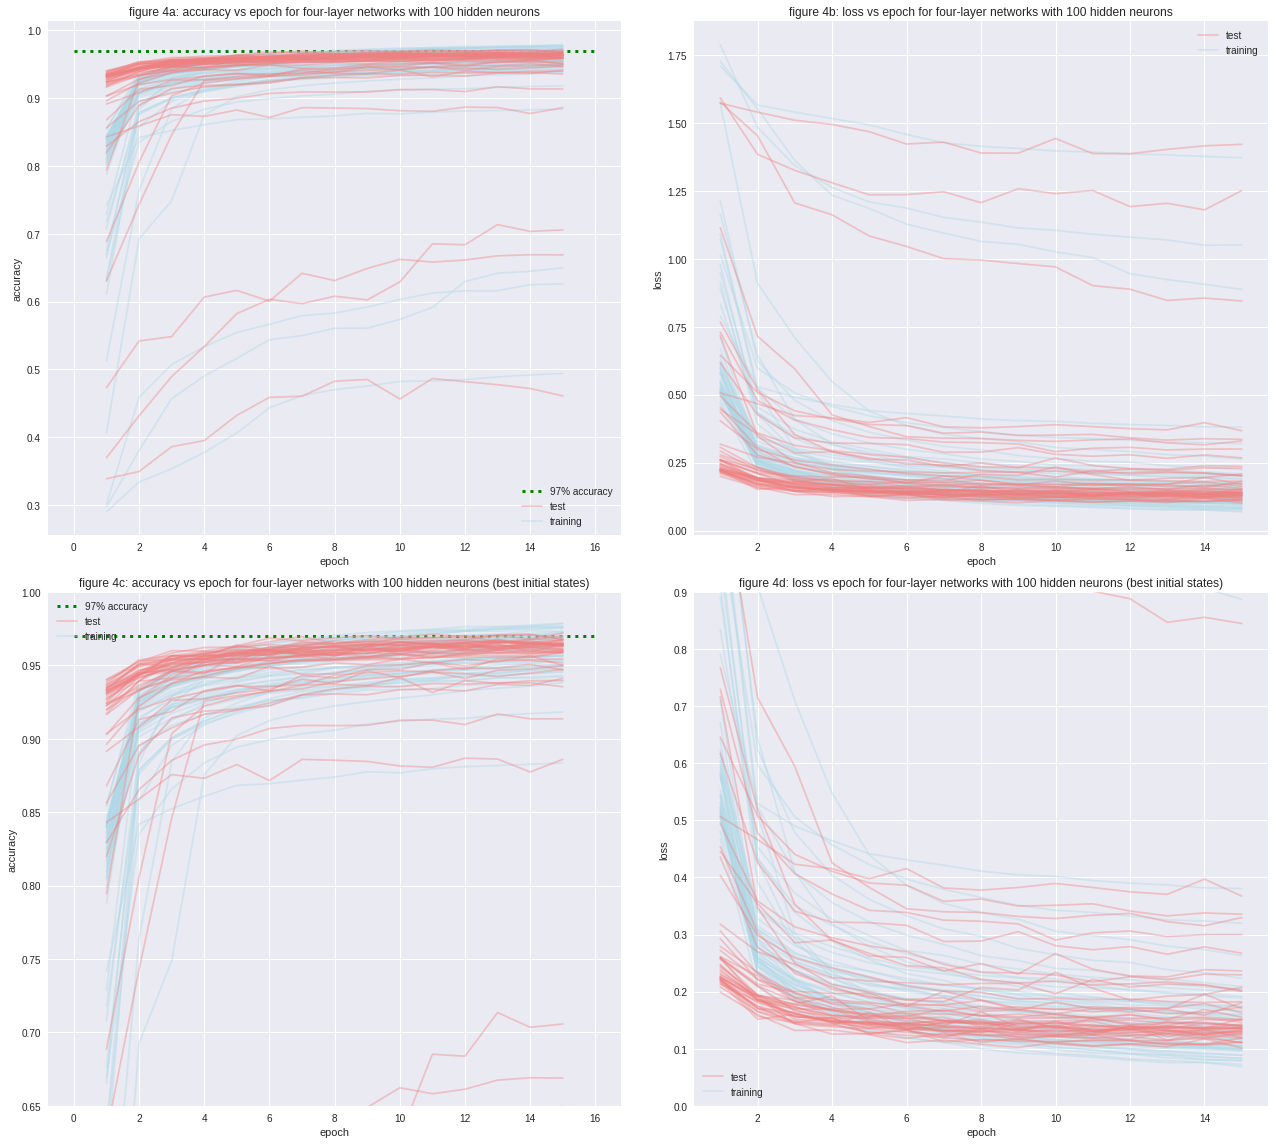

In [61]:
fig4 = plt.figure(figsize=(18,16))

ax4a = fig4.add_subplot(2,2,1)
ax4a.plot(vectorized_acc_loss['four_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['four_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax4a.plot(vectorized_acc_loss['four_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['four_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax4a.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax4a.legend(handles, labels, loc='best')
ax4a.set_xlabel('epoch')
ax4a.set_ylabel('accuracy')
ax4a.set_title('figure 4a: accuracy vs epoch for four-layer networks with 100 hidden neurons')

ax4b = fig4.add_subplot(2,2,2)
ax4b.plot(vectorized_acc_loss['four_layer_training_loss']['epoch'],
          vectorized_acc_loss['four_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax4b.plot(vectorized_acc_loss['four_layer_validation_loss']['epoch'],
          vectorized_acc_loss['four_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax4b.legend(handles, labels, loc='best')
ax4b.set_xlabel('epoch')
ax4b.set_ylabel('loss')
ax4b.set_title('figure 4b: loss vs epoch for four-layer networks with 100 hidden neurons')

ax4c = fig4.add_subplot(2,2,3)
ax4c.plot(vectorized_acc_loss['four_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['four_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax4c.plot(vectorized_acc_loss['four_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['four_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax4c.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
ax4c.set_ylim(0.65,1.0)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax4c.legend(handles, labels, loc='best')
ax4c.set_xlabel('epoch')
ax4c.set_ylabel('accuracy')
ax4c.set_title('figure 4c: accuracy vs epoch for four-layer networks with 100 hidden neurons (best initial states)')

ax4d = fig4.add_subplot(2,2,4)
ax4d.plot(vectorized_acc_loss['four_layer_training_loss']['epoch'],
          vectorized_acc_loss['four_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax4d.plot(vectorized_acc_loss['four_layer_validation_loss']['epoch'],
          vectorized_acc_loss['four_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
ax4d.set_ylim(0,0.9)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax4d.legend(handles, labels, loc='best')
ax4d.set_xlabel('epoch')
ax4d.set_ylabel('loss')
ax4d.set_title('figure 4d: loss vs epoch for four-layer networks with 100 hidden neurons (best initial states)')

plt.tight_layout()
plt.show()




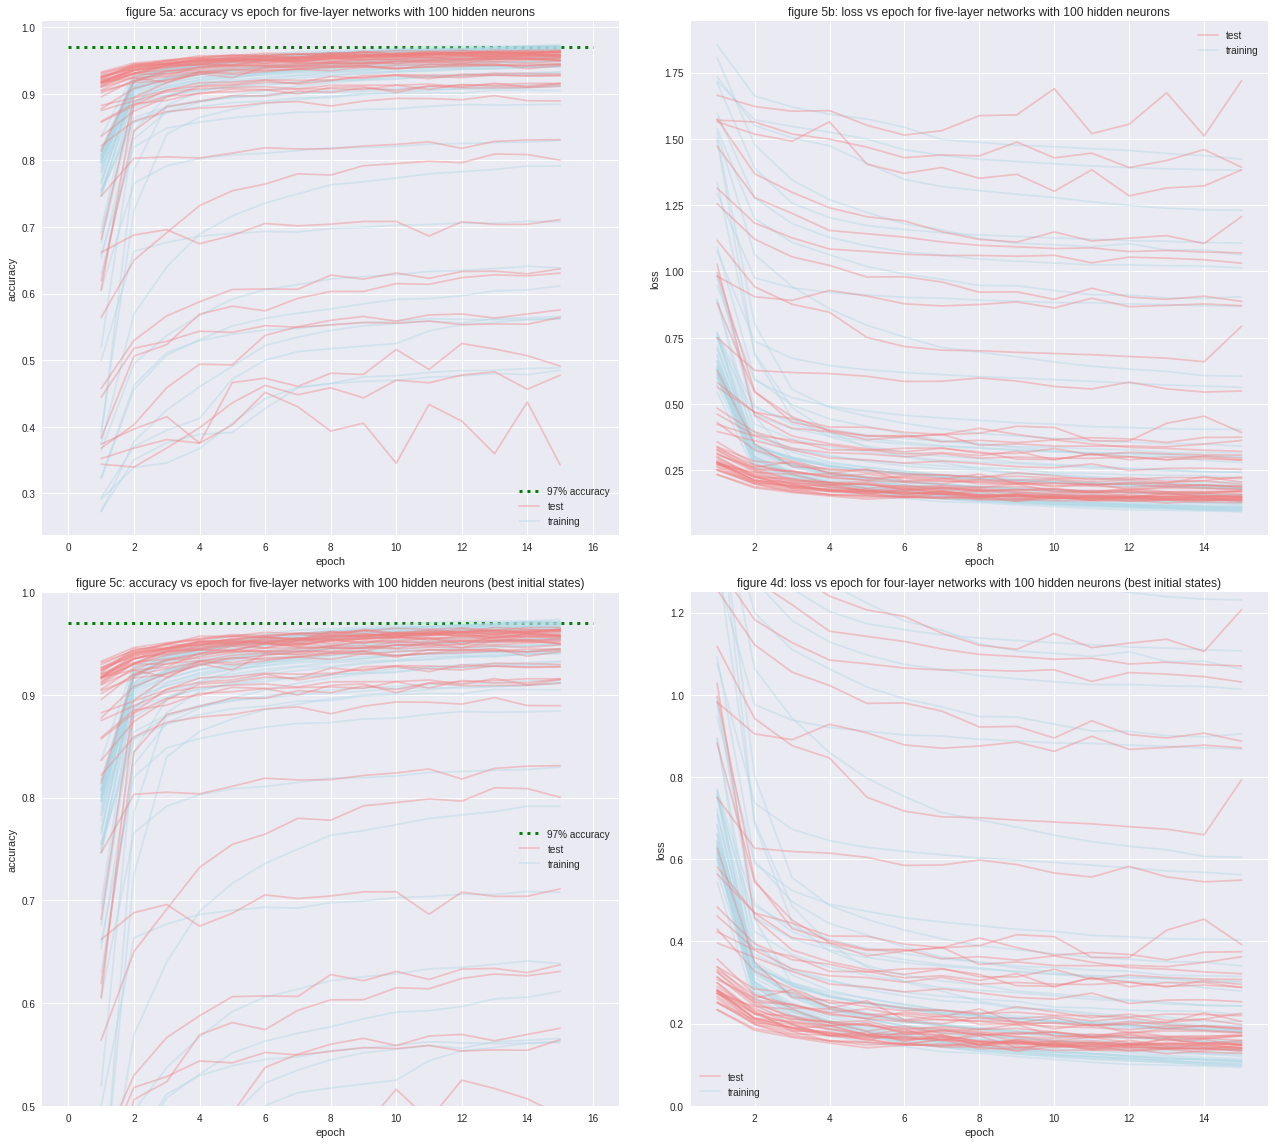

In [62]:
fig5 = plt.figure(figsize=(18,16))

ax5a = fig5.add_subplot(2,2,1)
ax5a.plot(vectorized_acc_loss['five_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['five_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax5a.plot(vectorized_acc_loss['five_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['five_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax5a.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax5a.legend(handles, labels, loc='lower right')
ax5a.set_xlabel('epoch')
ax5a.set_ylabel('accuracy')
ax5a.set_title('figure 5a: accuracy vs epoch for five-layer networks with 100 hidden neurons')

ax5b = fig5.add_subplot(2,2,2)
ax5b.plot(vectorized_acc_loss['five_layer_training_loss']['epoch'],
          vectorized_acc_loss['five_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax5b.plot(vectorized_acc_loss['five_layer_validation_loss']['epoch'],
          vectorized_acc_loss['five_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax5b.legend(handles, labels, loc='upper right')
ax5b.set_xlabel('epoch')
ax5b.set_ylabel('loss')
ax5b.set_title('figure 5b: loss vs epoch for five-layer networks with 100 hidden neurons')

ax5c = fig5.add_subplot(2,2,3)
ax5c.plot(vectorized_acc_loss['five_layer_training_accuracy']['epoch'],
          vectorized_acc_loss['five_layer_training_accuracy'][iter_cols],
          label = 'training',
          color='lightblue', alpha=0.4)
ax5c.plot(vectorized_acc_loss['five_layer_validation_accuracy']['epoch'],
          vectorized_acc_loss['five_layer_validation_accuracy'][iter_cols],
          label = 'test',
          color='lightcoral', alpha=0.4)
ax5c.hlines(y=0.97,xmin=0,xmax=16,label='97% accuracy',colors='green',linestyles=':',linewidth=3)
ax5c.set_ylim(0.5,1.0)
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax5c.legend(handles, labels, loc='center right')
ax5c.set_xlabel('epoch')
ax5c.set_ylabel('accuracy')
ax5c.set_title('figure 5c: accuracy vs epoch for five-layer networks with 100 hidden neurons (best initial states)')

ax5d = fig5.add_subplot(2,2,4)
ax5d.plot(vectorized_acc_loss['five_layer_training_loss']['epoch'],
          vectorized_acc_loss['five_layer_training_loss'][iter_cols],
          label='training',
          color='lightblue',
          alpha=0.4)
ax5d.plot(vectorized_acc_loss['five_layer_validation_loss']['epoch'],
          vectorized_acc_loss['five_layer_validation_loss'][iter_cols],
          label='test',
          color='lightcoral',
          alpha=0.4)
ax5d.set_ylim(0,1.25)
# Making sure labels aren't repeated
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax5d.legend(handles, labels, loc='best')
ax5d.set_xlabel('epoch')
ax5d.set_ylabel('loss')
ax5d.set_title('figure 4d: loss vs epoch for four-layer networks with 100 hidden neurons (best initial states)')

plt.tight_layout()
plt.show()

It's easy to see the progressive decline of overall validation accuracy as the number of layers we have in the network increases (holding the total number of neurons the same). I now isolate the architectures which performed above the 97% accuracy threshold and look at their training times.

In [78]:
iter_cols = ['iter'+str(i) for i in range(1,51)]
single_layer_above_thresh = (vectorized_acc_loss['single_layer_validation_accuracy'].iloc[14][iter_cols] >0.97)
single_layer_ata = timing_dict['single_layer'].loc[single_layer_above_thresh[single_layer_above_thresh].index.to_list()] # ata=abovethreshaccuracy
single_layer_att = single_layer_ata['training_time'].sort_values()[0:5]

IterNumber
iter12    45.622257
iter19    45.757916
iter10    45.853637
iter11    45.894270
iter6     45.943396
Name: training_time, dtype: float64

In [80]:
two_layer_above_thresh = (vectorized_acc_loss['two_layer_validation_accuracy'].iloc[14][iter_cols] >0.97)
two_layer_ata = timing_dict['two_layer'].loc[two_layer_above_thresh[two_layer_above_thresh].index.to_list()]
two_layer_att = two_layer_ata['training_time'].sort_values()[0:10]

IterNumber
iter24    49.131674
iter25    49.204289
iter26    49.386607
iter48    49.896138
iter36    49.954691
iter40    50.042086
iter31    50.050322
iter15    50.173345
iter42    50.224807
iter7     50.323256
Name: training_time, dtype: float64

In [81]:
three_layer_above_thresh = (vectorized_acc_loss['three_layer_validation_accuracy'].iloc[14][iter_cols] >0.97)
three_layer_ata = timing_dict['three_layer'].loc[three_layer_above_thresh[three_layer_above_thresh].index.to_list()]
three_layer_att = three_layer_ata['training_time'].sort_values()[0:10]

In [95]:
# Four and five layer architectures have few networks above 97% accuracy, so we lower to 96% to eke out more data
four_layer_above_thresh = (vectorized_acc_loss['four_layer_validation_accuracy'].iloc[14][iter_cols] >0.96)
four_layer_ata = timing_dict['four_layer'].loc[four_layer_above_thresh[four_layer_above_thresh].index.to_list()]
four_layer_att = four_layer_ata['training_time'].sort_values()[0:10]
four_layer_att

IterNumber
iter29    53.828911
iter23    54.229976
iter3     54.338394
iter8     54.526557
iter6     54.773837
iter20    54.793901
iter32    55.005810
iter48    55.072360
iter28    55.144182
iter50    55.191000
Name: training_time, dtype: float64

In [85]:
five_layer_above_thresh = (vectorized_acc_loss['five_layer_validation_accuracy'].iloc[14][iter_cols] >0.96)
five_layer_ata = timing_dict['five_layer'].loc[five_layer_above_thresh[five_layer_above_thresh].index.to_list()]
five_layer_att = five_layer_ata['training_time'].sort_values()[0:10]

In [157]:
best_two_layer_architectures = architectures_dict['two_layer'][two_layer_att.index.to_list()]
best_three_layer_architectures = architectures_dict['three_layer'][three_layer_att.index.to_list()]
best_four_layer_architectures = architectures_dict['four_layer'][four_layer_att.index.to_list()]
best_five_layer_architectures = architectures_dict['five_layer'][five_layer_att.index.to_list()]
best_architectures = [best_two_layer_architectures,best_three_layer_architectures,best_four_layer_architectures,best_five_layer_architectures]
layer_sizes = [i for i in range(3,7)]
for (arch,size) in zip(best_architectures,layer_sizes):
    arch.dropna(inplace=True)
    arch['layer'] = [l for l in range(1,size+1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Now, we produce plots to visualize training time as well as architecture. Note that in the architecture visualization, a layer with zero neurons is equivalent to a dropout layer.

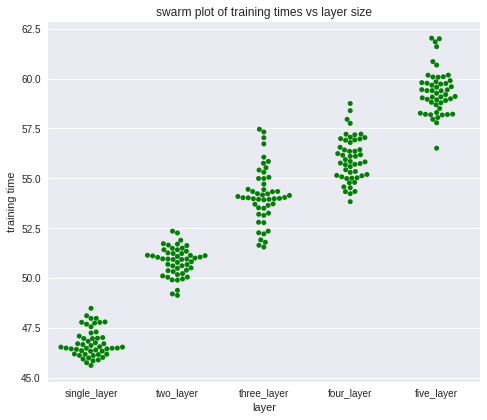

In [202]:
fig6 = plt.figure(figsize=(6,5))
ax6 = fig6.add_axes((1,1,1,1))
timing_data_seaborn = pd.DataFrame()
for name in save_names:
    timing_data_seaborn[name] = timing_dict[name]['training_time']
timing_data_seaborn = timing_data_seaborn.melt(value_vars=save_names)
timing_data_seaborn.columns = ['layer','training time']
sns.swarmplot(x='layer',y='training time',data=timing_data_seaborn,
              color = 'green')
plt.title('swarm plot of training times vs layer size')
plt.show()

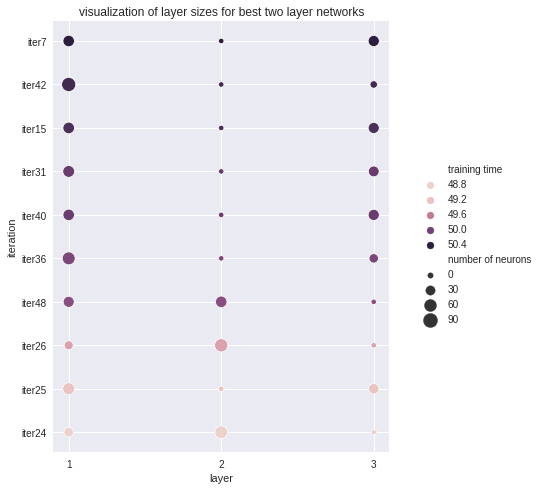

In [219]:
b2la_seaborn = best_two_layer_architectures.melt(id_vars='layer')
two_layer_melted_times = []
for t in timing_dict['two_layer'].loc[two_layer_att.index.to_list()].values:
    two_layer_melted_times += [y for x in t for y in [x]*3]
b2la_seaborn.columns = ['layer','iteration','number of neurons']
b2la_seaborn['training time'] = two_layer_melted_times
fig7 = sns.relplot(x='layer',y='iteration',data=b2la_seaborn,
            size='number of neurons',sizes=(30,200),
            hue='training time')
fig7.fig.set_size_inches((8,7))
plt.xticks([1,2,3])
plt.title('visualization of layer sizes for best two layer networks')
plt.show()

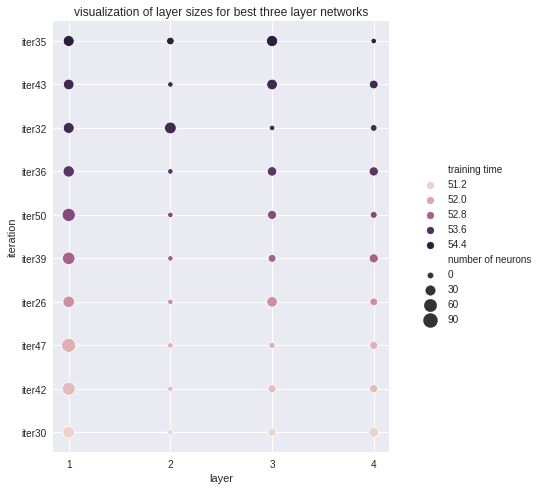

In [222]:
b3la_seaborn = best_three_layer_architectures.melt(id_vars='layer')
three_layer_melted_times = []
for t in timing_dict['three_layer'].loc[three_layer_att.index.to_list()].values:
    three_layer_melted_times += [y for x in t for y in [x]*4]
b3la_seaborn.columns = ['layer','iteration','number of neurons']
b3la_seaborn['training time'] = three_layer_melted_times
fig8 = sns.relplot(x='layer',y='iteration',data=b3la_seaborn,
            size='number of neurons',sizes=(30,200),
            hue='training time')
fig8.fig.set_size_inches((8,7))
plt.xticks([1,2,3,4])
plt.title('visualization of layer sizes for best three layer networks')
plt.show()

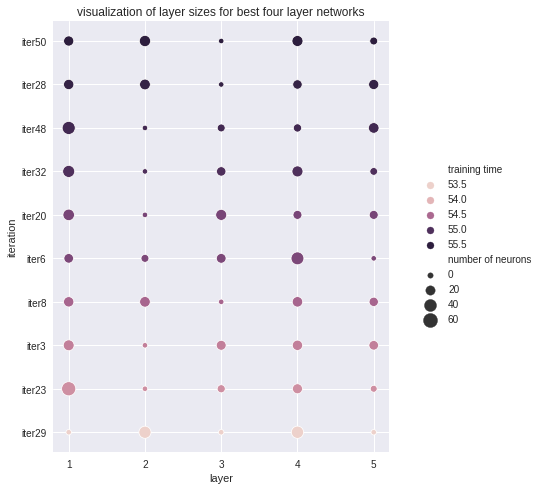

In [223]:
b4la_seaborn = best_four_layer_architectures.melt(id_vars='layer')
four_layer_melted_times = []
for t in timing_dict['four_layer'].loc[four_layer_att.index.to_list()].values:
    four_layer_melted_times += [y for x in t for y in [x]*5]
b4la_seaborn.columns = ['layer','iteration','number of neurons']
b4la_seaborn['training time'] = four_layer_melted_times
fig9 = sns.relplot(x='layer',y='iteration',data=b4la_seaborn,
            size='number of neurons',sizes=(30,200),
            hue='training time')
fig9.fig.set_size_inches((8,7))
plt.xticks([1,2,3,4,5])
plt.title('visualization of layer sizes for best four layer networks')
plt.show()

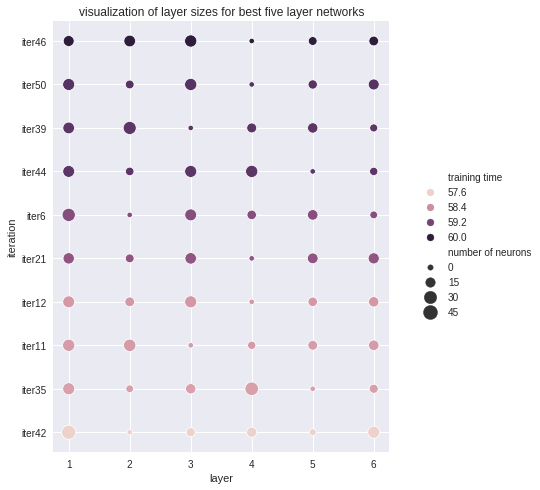

In [225]:
b5la_seaborn = best_five_layer_architectures.melt(id_vars='layer')
five_layer_melted_times = []
for t in timing_dict['five_layer'].loc[five_layer_att.index.to_list()].values:
    five_layer_melted_times += [y for x in t for y in [x]*6]
b5la_seaborn.columns = ['layer','iteration','number of neurons']
b5la_seaborn['training time'] = five_layer_melted_times
fig10 = sns.relplot(x='layer',y='iteration',data=b5la_seaborn,
            size='number of neurons',sizes=(30,200),
            hue='training time')
fig10.fig.set_size_inches((8,7))
plt.xticks([1,2,3,4,5,6])
plt.title('visualization of layer sizes for best five layer networks')
plt.show()

From these visualizations, we can see that the most efficient network architectures are those which are close to uniform. All of the architectures visualized above peformed at atleast above 96% accuracy, and the spread of training times for each of the most accurate sets was around 2 seconds. I imagine that training a network that is much larger will see this spread also get larger between the fastest (most uniform) network and the slowest (lopsided) network.

### Conclusions

This project was a fun and rewarding foray into an experimental exploration of network architecture and it's effects on training time, accuracy, and overall efficiency of performance on a benchmark dataset. By far, the fastest and most accurate results were achieved with single hidden layer networks coupled with a dropout layer. However, for multilayered networks, I found that the more lopsided a network is, the higher the training time; conversely, if a network was more uniform, it generally trained faster. A couple issues I realized I had in this project were the number of random networks generated for the higher-layer networks. For example, there are many more ways to distribute 100 neurons across five layers than across two layers. I think this skewed the data a bit by perhaps not hitting certain network architectures of four and five layers that may have trained at a higher accuracy. \\